# ◆Titanic: Machine Learning from Disaster
### 目的：タイタニック号の乗客のデータから、生存予測をする
#### 目的変数をSurvivedとする二値分類問題としてロジスティック回帰アルゴリズムを使ったモデルを作成する
- kaggle URL:https://www.kaggle.com/c/titanic/data
- Create Date：2019/01/05／Author：M.Hasegawa
#### ───────────────────────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 事前に予測できない項目は、除外する。
- 目的変数を説明するのに有効そうな説明変数を見つける。
- 目的変数と説明変数の関係を確認するためのグラフを作成する。
- 質的変数が扱えない場合は、ダミー変数に置き換える。

### 3.モデル生成
- ロジスティック回帰モデルを利用する
- モデルパラメータ（重み）：$\mathbf{w} = (w_0, w_1, w_2, \dots, w_p)^{\mathrm{T}} $
- モデルへの入力：$\mathbf{x} = (1, x_1, x_2, \dots, x_p)^{\mathrm{T}} $
- 以上の2つが与えられたときのモデルの出力（確率値）：$\hat{Y}(\mathbf{x}; \mathbf{w}) =  f(\mathbf{w}^{\mathrm{T}} \mathbf{x})$
- $f$はシグモイド関数：$f(x) = \frac{1}{1 + \exp(-x)}$

### 4.モデル評価
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

### 5.テストデータ予測


### ※データセット
- 「train.csv」（学習データ数：891行12列）
- 「test.csv」（テストデータ数：418行11列 ※Survived列がない）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | PassengerId |識別ID | - | - |
|  2 | Survived | 生存有無 | - | ○ |
|  3 | Pclass | チケットクラス | - | ○ |
|  4 | Name | 名前 | - | - |
|  5 | Sex | 性別 | - | ○ |
|  6 | Age | 年齢 | 欠損あり | ○ |
|  7 | SibSp | タイタニック号に乗る兄弟/配偶者の数 | - | ○ |
|  8 | Parch | タイタニック号に乗る親/子供の数 | - | ○ |
|  9 | Ticket | チケット | - | - |
| 10 | Fare | 旅客運賃 | 欠損あり | ○ |
| 11 | Cabin | 客室番号 | 欠損あり | - |
| 12 | Embarked| 乗船港 C =シェルブール、Q =クイーンズタウン、S =サザンプトン | 欠損あり | ○ |

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support

# ============================================================================
# 関数：各データの件数を確認するグラフ
# 引数：データフレーム、データ名,グラフの横幅、縦幅、降順ソート指定
# ============================================================================
def show_state_count_plot(p_df, col_name, w, h, sort_flg=False):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        print("\n▼ " + str(col_name) + "別の生存数と死亡数（降順）")
        ax = sns.countplot(p_df[col_name],hue=p_df['Survived'],order = p_df[col_name].value_counts().index)
    else:
        print("\n▼ " + str(col_name) + "別の生存数と死亡数 ")
        ax = sns.countplot(p_df[col_name],hue=p_df['Survived'])
        
    ax.set_title("Count by " + str(col_name))
    ax.set_xlabel(col_name)
    ax.set_ylabel("Count")
    plt.legend()
    plt.show()

# ============================================================================
# 関数：各データの成功率を確認するグラフ
# 引数：データフレーム、データ名,グラフの横幅、縦幅、降順ソート有無
# ============================================================================
def show_s_rate_barplot(p_df, col_name, w, h, sort_flg=False):
    s_rate = pd.DataFrame(p_df['Survived'].groupby(p_df[col_name]).mean())
    s_rate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        s_rate = s_rate.sort_values('Survived', ascending=False)
        print("\n▼ " + str(col_name) + "別の生存率（降順）")
    else:
        print("\n▼ " + str(col_name) + "別の生存率")
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y="Survived", data=s_rate)
    ax.set_title("Survived rate by " + str(col_name))
    ax.set_xlabel(col_name)
    ax.set_ylabel("Ratio")
    plt.show()

## 1.データ読込

In [2]:
# ****************************************************************************
# ◆ 1.データ読込
# ****************************************************************************
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

print('\n▼ データ数確認')
print('train data shape ---------> ' + str(train.shape))
print('test data shape  ---------> ' + str(test.shape))

print("\n▼ 先頭5行表示")
display(train.head(5))

print("\n▼ 基本統計量")
display(train.describe())

print('\n▼ 生存率平均')
print(train['Survived'].mean())

# 学習データとテストデータのマージ
train_tmp = train
test_tmp = test
train_tmp['tag'] = 'train'
test_tmp['tag'] = 'test'
test_tmp['Survived'] = -1   #仮置き
all_df = pd.concat([train_tmp,test_tmp],axis=0,sort=False).reset_index(drop=True)

print('\n▼ 欠損データ確認')
display(pd.DataFrame(all_df.isnull().sum()[all_df.isnull().sum()>0],columns=['Missing num']))


▼ データ数確認
train data shape ---------> (891, 12)
test data shape  ---------> (418, 11)

▼ 先頭5行表示


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



▼ 基本統計量


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



▼ 生存率平均
0.3838383838383838

▼ 欠損データ確認


,Missing num
Age,263
Fare,1
Cabin,1014
Embarked,2


## 2.データ前処理
### 2-1.欠損値の補完

In [3]:
# ****************************************************************************
# ◆ 2.データ前処理
# ****************************************************************************

# ------------------------------------------------
# 2-1.欠損値の補完
# ------------------------------------------------
# 欠損値の補完
all_df['Age'] = all_df['Age'].fillna(all_df['Age'].median()) # 中央値
all_df['Fare'] = all_df['Fare'].fillna(all_df['Fare'].median()) # 中央値

# 欠損項目除外
all_df = all_df.drop(['Cabin'], axis=1)
all_df = all_df.drop(['Embarked'], axis=1)

# 不要項目除外
all_df = all_df.drop(['Ticket'], axis=1)

print('\n▼ データ確認')
display(all_df.head(5))


▼ データ確認


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,tag
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,train
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,train
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,train
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,train
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,train


### 2-2.目的変数の前処理


▼ Pclass別の生存数と死亡数 


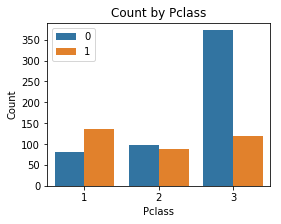


▼ Pclass別の生存率


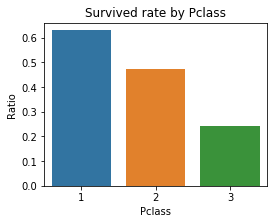


▼ 学習データとテストデータのPclassの乗客数の分布に大きな偏りはない


tag,test,train
Pclass,,
1,0.255981,0.242424
2,0.222488,0.206510
3,0.521531,0.551066



→ 結論：Pclassはダミー変換して利用する


In [4]:
# ------------------------------------------------
# 2-2-1.Pclassの確認
# ------------------------------------------------
train = all_df.query("tag == 'train'")

# Pclass別の生存数カウント
show_state_count_plot(train,"Pclass",4,3)
# Pclass別の生存率
show_s_rate_barplot(train,"Pclass",4,3)

# Pclassの分布
print("\n▼ 学習データとテストデータのPclassの乗客数の分布に大きな偏りはない")
display(pd.crosstab(all_df['Pclass'],all_df['tag'],normalize='columns'))
print("\n→ 結論：Pclassはダミー変換して利用する")


▼ 学習データとテストデータの敬称を比較


tag,test,train
honorific,,
Capt,0,1
Col,2,2
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,0,1
Major,0,2
Master,21,40



→学習データにしか現れない敬称を除外する
['Capt', 'Don', 'Jonkheer', 'Lady', 'Major', 'Mile', 'Mme', 'Sir', 'the Countess']

▼ honorific別の生存率（降順）


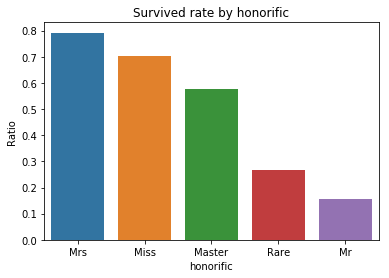


▼ honorific別の生存数と死亡数（降順）


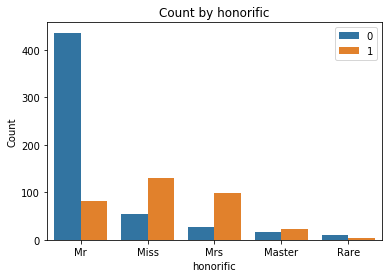


▼ 敬称別の生存率とレコード数


,mean,count
honorific,,
Master,0.575000,40
Miss,0.702703,185
Mr,0.156673,517
Mrs,0.792000,125
Rare,0.266667,15



→ 結論：Nameは除外し、honorificをダミー変換して利用する


In [5]:
# ------------------------------------------------
# 2-2-2.Nameの確認
# ------------------------------------------------
train = all_df.query("tag == 'train'")

print("\n▼ 学習データとテストデータの敬称を比較")
all_df['honorific'] = all_df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
display(pd.crosstab(all_df['honorific'],all_df['tag']) )

print("\n→学習データにしか現れない敬称を除外する")
only_train_honorific = ['Capt','Don','Jonkheer','Lady','Major','Mile','Mme','Sir','the Countess']
print(only_train_honorific)

# レコード除外
all_df = all_df[~all_df['honorific'].isin(only_train_honorific) ].reset_index(drop=True)

# 敬称を統合し、ダミー変換する
all_df['honorific'].replace(['Col','Dr', 'Rev'], 'Rare',inplace=True) #少数派の敬称を統合
all_df['honorific'].replace('Mlle', 'Miss',inplace=True) #Missに統合
all_df['honorific'].replace('Ms', 'Miss',inplace=True) #Missに統合

# 再取得
train = all_df.query("tag == 'train'")

# 学習データでのグラフ表示
show_s_rate_barplot(train,"honorific",6,4, True)
show_state_count_plot(train,"honorific",6,4, True)

print("\n▼ 敬称別の生存率とレコード数")
display(train['Survived'].groupby(train['honorific']).agg(['mean','count']))
print("\n→ 結論：Nameは除外し、honorificをダミー変換して利用する")


▼ Fare(運賃)をSurvivedに分けて分布を確認 歪度: 4.793762193666624


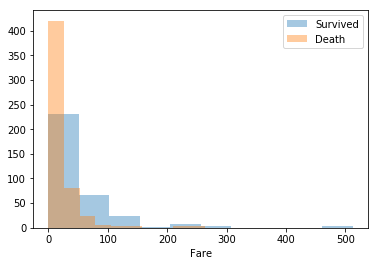


▼ 分布が歪んでいるためFareを対数変換して再度分布を確認


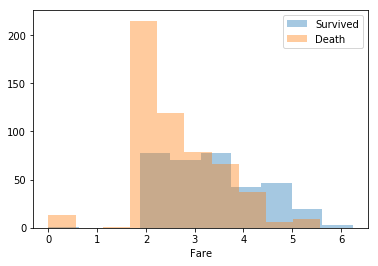

→ 結論：Fareは、標準化して利用する


In [6]:
# ------------------------------------------------
# 2-2-3.Fare(運賃)の確認
# ------------------------------------------------
print("\n▼ Fare(運賃)をSurvivedに分けて分布を確認 歪度:", train['Fare'].skew())
# Fareの分布
sns.distplot(train[train['Survived']==1]['Fare'],kde=False,rug=False,bins=10,label='Survived')
sns.distplot(train[train['Survived']==0]['Fare'],kde=False,rug=False,bins=10,label='Death')
plt.legend()
plt.show()

print("\n▼ 分布が歪んでいるためFareを対数変換して再度分布を確認")
sns.distplot(np.log1p(train[train['Survived']==1]['Fare']),kde=False,rug=False,bins=10,label='Survived')
sns.distplot(np.log1p(train[train['Survived']==0]['Fare']),kde=False,rug=False,bins=10,label='Death')
plt.legend()
plt.show()
print("→ 結論：Fareは、標準化して利用する")


▼ Ageの分布


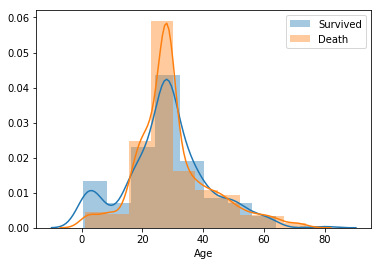

→ 0～20歳までの分布に差が大きく、子供は生き残りやすかったといえる。
→ 結論：Ageは、標準化して利用する


In [7]:
# ------------------------------------------------
# 2-2-4.Age(年齢)の確認
# ------------------------------------------------
print("\n▼ Ageの分布")
# Ageの分布
sns.distplot(all_df[all_df['Survived']==1]['Age'],kde=True,rug=False,bins=10,label='Survived') #生存者の分布
sns.distplot(all_df[all_df['Survived']==0]['Age'],kde=True,rug=False,bins=10,label='Death') #死者の分布
plt.legend()
plt.show()
print("→ 0～20歳までの分布に差が大きく、子供は生き残りやすかったといえる。")
print("→ 結論：Ageは、標準化して利用する")


▼ FamilySize別の生存率


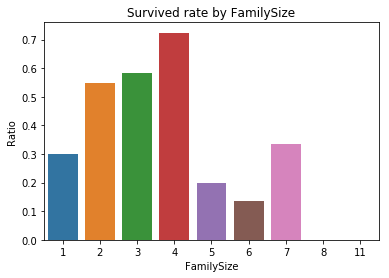


▼ FamilySize別の生存数と死亡数 


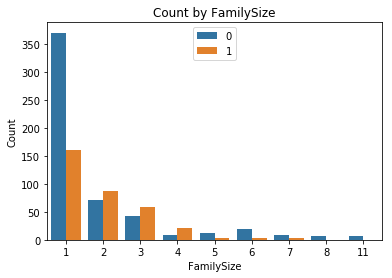


→単身者は死亡率が高く、2人～4人の家族の生存率は高く、5人以上は死亡率が高い。

▼ FamilySize_bin別の生存率


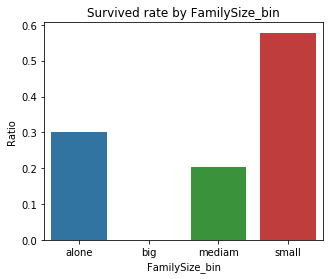


→ 結論：Parch、SibSp、FamilySizeを除外し、FamilySize_binをダミー変換して利用する


In [8]:
# ------------------------------------------------
# 2-2-5.同乗者数（Parch、SibSp）の確認
# ------------------------------------------------
# 家族数 = Parch + SibSp + 1
all_df['FamilySize'] = all_df['Parch'] + all_df['SibSp'] + 1 #ALLデータ

train = all_df.query("tag == 'train'")

# 家族数ごとの分布を確認
show_s_rate_barplot(train,"FamilySize",6,4)
show_state_count_plot(train,"FamilySize",6,4)

print("\n→単身者は死亡率が高く、2人～4人の家族の生存率は高く、5人以上は死亡率が高い。")

# FamilySizeを離散化
all_df['FamilySize_bin'] = 'big'
all_df.loc[all_df['FamilySize']==1,'FamilySize_bin'] = 'alone'
all_df.loc[(all_df['FamilySize']>=2) & (all_df['FamilySize']<=4),'FamilySize_bin'] = 'small'
all_df.loc[(all_df['FamilySize']>=5) & (all_df['FamilySize']<=7),'FamilySize_bin'] = 'mediam'

# FamilySizeを離散化したときの生存率
train = all_df.query("tag == 'train'")
show_s_rate_barplot(train,"FamilySize_bin",5,4)

print("\n→ 結論：Parch、SibSp、FamilySizeを除外し、FamilySize_binをダミー変換して利用する")

### 2-3.ダミー変換

In [9]:
# ------------------------------------------------
# 2-3.ダミー変換
# ------------------------------------------------

# 訓練データを利用
train = all_df.query("tag == 'train'")

# 抽出元の不要な項目を削除
train = train.drop(['PassengerId','Name','Parch','SibSp','FamilySize','tag'], axis=1)

# one-hot-encoding
train = pd.get_dummies(train, columns=['Pclass','Sex','FamilySize_bin','honorific'])

train['honorific_Dona'] = 0

### 2-4.データ標準化

In [10]:
# ------------------------------------------------
# 2-4.データ標準化
# ------------------------------------------------
scaler = StandardScaler()
train['Fare'] = scaler.fit_transform(train.loc[:, ['Fare']])
train['Age'] = scaler.fit_transform(train.loc[:, ['Age']])

print("\n▼ 先頭5行表示")
display(train.head(5))


▼ 先頭5行表示


,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,FamilySize_bin_alone,FamilySize_bin_big,FamilySize_bin_mediam,FamilySize_bin_small,honorific_Master,honorific_Miss,honorific_Mr,honorific_Mrs,honorific_Rare,honorific_Dona
0,0,-0.557494,-0.498077,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0
1,1,0.679867,0.786910,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0
2,1,-0.248153,-0.484532,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0
3,1,0.447862,0.422017,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,0,0.447862,-0.482023,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0


## 3.モデル生成


▼ 回帰係数を表示（絶対値の降順：Top10）


,feature,weight
0,FamilySize_bin_big,-26.402650
1,FamilySize_bin_alone,9.084192
2,FamilySize_bin_small,8.363398
3,Sex_male,-6.593718
4,FamilySize_bin_mediam,5.294166
5,honorific_Miss,-5.281260
6,honorific_Mrs,-5.003318
7,honorific_Master,4.905315
8,Sex_female,2.932824
9,Pclass_3,-2.609536


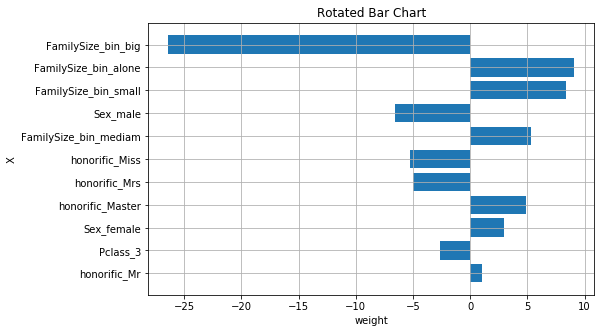

In [11]:
# ****************************************************************************
# ◆ 3.モデル作成
# ****************************************************************************
# ------------------------------------------------
# 3-1.モデルを生成して学習する  
# ------------------------------------------------
X = train.drop('Survived', axis=1).values # 説明変数
y = train['Survived'].values              # 目的変数

# ロジスティック回帰モデル生成
clf = SGDClassifier(loss='log',           # ロジスティック回帰を指定
                    penalty='none',       # 正則化を入れる場合はL1､L2→Day2で実施
                    max_iter=10000,       # 繰り返し計算時の強制的終了値、誤差が収束すれば利用しない。
                    fit_intercept=True,   # 切片を有効にするかどうか
                    random_state=1234,    # 乱数のシード
                    tol=1e-3              # 収束する誤差の指定
                   )

# 学習
clf.fit(X, y)

#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# リストへ変換
list_f = list(train.drop('Survived', axis=1).columns)
list_w = np.reshape(clf.coef_[0], -1).tolist()

# 重みを表示
list_df = pd.DataFrame(columns=['feature','weight','abs_w'])
for i, feature in enumerate(list_f):
    #print(feature.ljust(30, ' ') + "---->   w{:.0f} = {:.3f}".format(i + 1, list_w[i]))
    list_df = list_df.append( pd.Series([feature,list_w[i],abs(list_w[i])],index=list_df.columns), ignore_index=True)

# 絶対値の降順ソートトップ10
print("\n▼ 回帰係数を表示（絶対値の降順：Top10）")
list_df = list_df.sort_values('abs_w', ascending=False)
list_df.reset_index(drop=True,inplace=True)
list_df = list_df.drop('abs_w', axis=1)
list_head = list_df.head(11)
display(list_head)

# グラフで表示
plt.figure(figsize=(8, 5))
plt.barh(np.arange(len(list_head['feature']))[::-1], list_head['weight'], align='center')
plt.yticks(np.arange(len(list_head['feature']))[::-1], list_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('X')
plt.grid()
plt.show()

## 4.モデル評価

In [12]:
# ****************************************************************************
# ◆ 4.モデル評価
# ****************************************************************************

# ラベルを予測
y_est = clf.predict(X)

#print('\n▼ モデルの予測結果(先頭10件)')
#print(y_est[:11])

# 予測確率を出力
#print('\n▼ 結果の予測確率(先頭10件)\n(失敗する確率：成功する確率):')
#print(clf.predict_proba(X)[:11].astype(float))
#print('\n▼ モデルの評価結果')

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
print('\n▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 死亡', '正解 = 生存'], 
                        columns=['予測 = 死亡', '予測 = 生存'])

display(conf_mat)

対数尤度 = -6.109
正答率 = 82.313%
適合率（Precision※精度) = 82.255%
再現率（Recall※検出率) = 91.009%
F1値（F1-score） = 86.411%

▼ 混同行列


,予測 = 死亡,予測 = 生存
正解 = 死亡,496,49
正解 = 生存,107,230


## 5.テストデータ予測

In [17]:
# ****************************************************************************
# ◆ 5.テストデータ予測
# ****************************************************************************
# ------------------------------------------------
# 5-1.ダミー変換
# ------------------------------------------------

# テストデータを利用
test = all_df.query("tag == 'test'")

# 抽出元の不要な項目を削除
test = test.drop(['PassengerId','Name','Parch','SibSp','FamilySize','tag','Survived'], axis=1)

# one-hot-encoding
test = pd.get_dummies(test, columns=['Pclass','Sex','FamilySize_bin','honorific'])

# ------------------------------------------------
# 5-2.データ標準化
# ------------------------------------------------
scaler = StandardScaler()
test['Fare'] = scaler.fit_transform(test.loc[:, ['Fare']])
test['Age'] = scaler.fit_transform(test.loc[:, ['Age']])

X = test.values # 説明変数

# ラベルを予測
y_test_pred = clf.predict(X)

print('\n▼ モデルの予測結果(先頭10件)')
print(y_test_pred[:11])

# 予測確率を出力
print('\n▼ 結果の予測確率(先頭10件)\n(失敗する確率：成功する確率):')
print(clf.predict_proba(X)[:11].astype(float))

# 予測結果を結合してCSV出力する
csv_test = all_df.query("tag == 'test'")
csv_test['Survived'] = y_test_pred
csv_test.loc[:, ['PassengerId', 'Survived']].to_csv('./titanic_submission.csv', index=False, header=True)


▼ モデルの予測結果(先頭10件)
[0 1 0 0 1 0 1 0 1 0 0]

▼ 結果の予測確率(先頭10件)
(失敗する確率：成功する確率):
[[9.99897782e-01 1.02218273e-04]
 [6.74483728e-03 9.93255163e-01]
 [9.99732331e-01 2.67669175e-04]
 [9.99877146e-01 1.22853648e-04]
 [3.56880877e-03 9.96431191e-01]
 [9.99832610e-01 1.67389898e-04]
 [1.51498671e-03 9.98485013e-01]
 [9.99629578e-01 3.70422437e-04]
 [1.67171743e-03 9.98328283e-01]
 [9.99918941e-01 8.10590624e-05]
 [9.99880956e-01 1.19044373e-04]]


C:\Users\arsma\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
